In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

from gnnad.graphanomaly import GNNAD
from gnnad.generate import GenerateGaussian, GenerateAnomaly

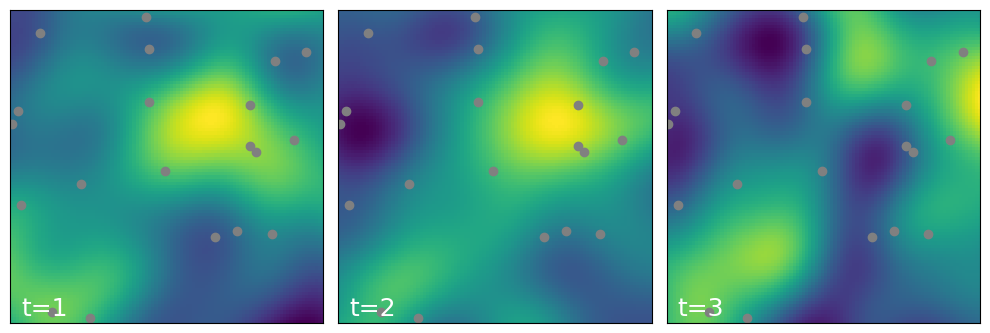

In [3]:
# generate data
gengauss = GenerateGaussian()
X = gengauss.generate()
gengauss.field_plot()


In [4]:
# split train test
X_train, X_test = train_test_split(X, shuffle=False)

# generate anomalies on test set
anoms = GenerateAnomaly(X_test)
X_test = anoms.generate_anomaly(anoms.variability, lam = 3, prop_anom = 0.07, seed=45)
X_test = anoms.generate_anomaly(anoms.drift, lam = 11, prop_anom = 0.07, seed=234)
y_test = anoms.get_labels()

# TODO: plot input data

In [5]:
# run model
model = GNNAD(threshold_type="max_validation", slide_win=3, topk=5)
fitted_model = model.fit(X_train, X_test, y_test)


epoch (0 / 100) (Loss:0.49526575, ACU_loss:0.49526575)
epoch (1 / 100) (Loss:0.45239231, ACU_loss:0.45239231)
epoch (2 / 100) (Loss:0.43802607, ACU_loss:0.43802607)
epoch (3 / 100) (Loss:0.43398476, ACU_loss:0.43398476)
epoch (4 / 100) (Loss:0.40352929, ACU_loss:0.40352929)
epoch (5 / 100) (Loss:0.40874359, ACU_loss:0.40874359)
epoch (6 / 100) (Loss:0.39248109, ACU_loss:0.39248109)
epoch (7 / 100) (Loss:0.39175493, ACU_loss:0.39175493)
epoch (8 / 100) (Loss:0.37955558, ACU_loss:0.37955558)
epoch (9 / 100) (Loss:0.37162271, ACU_loss:0.37162271)
epoch (10 / 100) (Loss:0.35698426, ACU_loss:0.35698426)
epoch (11 / 100) (Loss:0.35649341, ACU_loss:0.35649341)
epoch (12 / 100) (Loss:0.35466003, ACU_loss:0.35466003)
epoch (13 / 100) (Loss:0.34450704, ACU_loss:0.34450704)
epoch (14 / 100) (Loss:0.32834929, ACU_loss:0.32834929)
epoch (15 / 100) (Loss:0.34838301, ACU_loss:0.34838301)
=========================** Result **============================

F1 score: 0.30303030303030304
precision: 0.1807

In [ ]:
# TODO: plot results 

c:\Users\n10907700\Anaconda3\envs\gdn_old\lib\site-packages\ipykernel_launcher.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
c:\Users\n10907700\Anaconda3\envs\gdn_old\lib\site-packages\ipykernel_launcher.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
c:\Users\n10907700\Anaconda3\envs\gdn_old\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


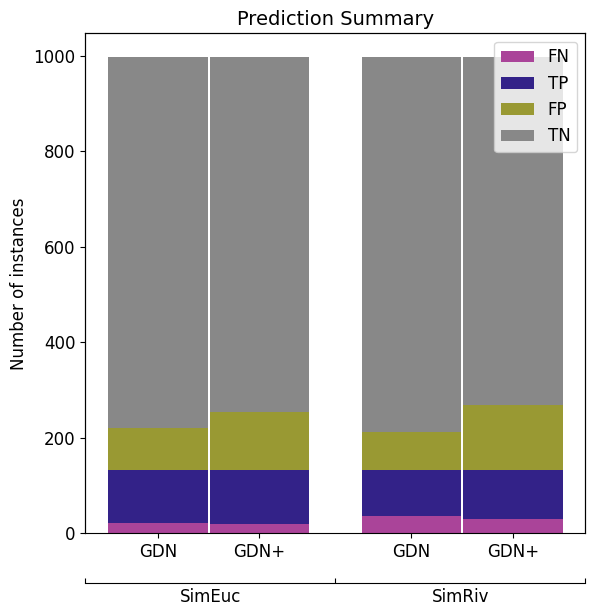

In [19]:
# plot confusion matrix

df = pd.DataFrame([[110, 776, 89, 22],
             [113, 743, 122, 19],
             [96, 784, 81, 36],
             [103, 729, 136, 29]], 
             columns=['TP', 'TN', 'FP', 'FN'])


import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

tp = df.TP.values
tn = df.TN.values
fp = df.FP.values
fn = df.FN.values

ind = [0, 1, 2.5, 3.5] # the x locations for the groups
width = 0.98
fig = plt.figure(figsize=(5, 5))
fig.set_tight_layout(True)
ax = fig.add_axes([0,0,1,1])

ax.bar(ind, fn, width, color='#AA4499')
ax.bar(ind, tp, width,bottom=fn, color='#332288')
ax.bar(ind, fp, width, bottom=fn+tp, color='#999933')
ax.bar(ind, tn, width, bottom=fp+fn+tp, color='#888888')
ax.set_ylabel('Number of instances' , fontsize=12)
ax.set_title('Prediction Summary', fontsize=14)
ax.set_xticks(ind, ('GDN', 'GDN+', 'GDN', 'GDN+'), fontsize=12)
ax.legend(labels=['FN', 'TP', 'FP', 'TN'], fontsize=12)

# Second X-axis
ax2 = ax.twiny()
ax2.spines["bottom"].set_position(("axes", -0.10))
ax2.tick_params('both', length=0, width=0, which='minor')
ax2.tick_params('both', direction='in', which='major')
ax2.xaxis.set_ticks_position("bottom")
ax2.xaxis.set_label_position("bottom")
ax2.set_xticks([0.0, 0.5, 1.0])
ax2.xaxis.set_major_formatter(ticker.NullFormatter())
ax2.xaxis.set_minor_locator(ticker.FixedLocator([0.25, 0.75]))
ax2.xaxis.set_minor_formatter(ticker.FixedFormatter(['SimEuc', 'SimRiv']))
ax2.tick_params(axis='both', which='minor', labelsize=12)
ax.tick_params(axis='y', labelsize= 12)

#plt.show()
#plt.autoscale()

#plt.savefig('ConfusionMatrix.pdf',bbox_inches='tight')